## ENGRI 1120: Magical Separation Units (MSU) calculations

### Introduction
Separations are a massive component of any chemical process. It is rarely the case that a reaction of interest goes to completion, and all we are left with is the desired product itself. Thus, we (as chemical engineers) must develop operations to pull apart (or separate) mixtures into streams that contain selected and undesired chemical components. For more on the general area of Separations (and the various types of tools that we can use), check out the [Separations section in the LearnCheme series](https://learncheme.com/screencasts/separations-mass-transfer/).For the project, we will develop a hypothetical downstream separation that illustrates some of the ideas you'll see in your later courses but without the headache that comes along with reality. 

### Theory
Suppose the teaching team invented a magical separation unit or MSU to make this happen. MSUs have one stream in and two streams out (called the top, and bottom, respectively) and a fixed separation ratio for all products (that's what makes them magical), where the desired product is _always_ in the top stream at some ratio $\theta$.

Denote the index for the desired product as $i=\star$. Then after one pass (stream 1 is the input, stream 2 is the top, and stream 3 is the bottom), we have:

$$\begin{eqnarray}
\dot{n}_{2,\star} &=& \theta\cdot\dot{n}_{1,\star}\\
\dot{n}_{3,\star} &=& (1-\theta)\cdot\dot{n}_{1,\star}\\
\end{eqnarray}$$

for the product. On the other hand, for _all_ other materials in the input, we have $\left(1-\theta_{\star}\right)$ in the top, and $\theta_{\star}$ in the bottom, i.e.,

$$\begin{eqnarray}
\dot{n}_{2,i} &=& (1-\theta)\cdot\dot{n}_{1,i}\qquad{\forall{i}\neq\star}\\
\dot{n}_{3,i} &=& \theta\cdot\dot{n}_{1,i}\\
\end{eqnarray}$$

If we chain these units together, we can achieve the desired degree of separation. This arrangement gives rise to a binary separation tree shown in Fig 2. 

<center>
    <img src="figs/Fig-BTree.pdf" style="align:right; width:30%">
</center>

Fig 2. [Binary separation tree](https://en.wikipedia.org/wiki/Binary_tree), where a single input stream is fractionated at each tree level at a fixed ratio.

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/notebooks-jupyter/ENGRI-1120-MSU-Example`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/notebooks-jupyter/ENGRI-1120-MSU-Example/Project.toml`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/notebooks-jupyter/ENGRI-1120-MSU-Example/Manifest.toml`


In [2]:
# load reqd packages and set paths -
using PrettyTables
using GLPK
using Plots
using Colors

# setup paths -
const _ROOT = pwd();

In [3]:
include("ENGRI-1120-Example-CodeLib.jl");

### Set some constants

In [4]:
# Constants -
θ = 0.75; # what is the split ratio 
𝒫 = 0.99; # what is my mole fraction purity target
number_of_levels = 10; # how many levels in the tree

In [5]:
# Build network from last time -
# Setup a collection of reaction strings -
reaction_array = Array{String,1}()

# encode the reactions -
# internal reactions -
push!(reaction_array,"v₁,A₁+x,B+y,false")
push!(reaction_array,"v₂,B,P,false")
push!(reaction_array,"v₃,A₂+y,C+x,false")

# compute the stoichiometric matrix -
# the optional expand arguement = should we split reversible reactions? (default: false)
(S, species_name_array, reaction_name_array) = build_stoichiometric_matrix(reaction_array; 
    expand=false);

In [6]:
(ℳ, ℛ) = size(S);

In [7]:
species_name_array

7-element Vector{String}:
 "A₁"
 "A₂"
 "B"
 "C"
 "P"
 "x"
 "y"

In [8]:
# from the FBA problen -
ṅ₃_out = [
    15.0 ; # A₁
    0.0  ; # A₂
    0.0  ; # B
    5.0  ; # C
    5.0  ; # P
    0.0  ; # x
    0.0  ; # y
];

In [9]:
# most of the "stuff" has a 1 - θ in the up, and a θ in the down
u = (1-θ)*ones(ℳ,1)
d = θ*ones(ℳ,1)

# However: the desired product has the opposite => correct for my compound of interest -
idx_target_compound = 5; # desired product is P -

# correct defaults -
u[idx_target_compound] = θ
d[idx_target_compound] = 1 - θ

# let's compute the composition of the *always up* stream -

# initialize some storage -
species_mole_flow_array_top = zeros(ℳ,number_of_levels)
species_mole_flow_array_bottom = zeros(ℳ,number_of_levels)

for species_index = 1:ℳ
    value = ṅ₃_out[species_index]
    species_mole_flow_array_top[species_index,1] = value
    species_mole_flow_array_bottom[species_index,1] = value
end

for level = 2:number_of_levels

    # compute the mass flows coming out of the top -
    mole_dot_top = ṅ₃_out.*(u.^(level-1))
    mole_dot_bottom = ṅ₃_out.*(d.^(level-1))

    # update my storage array -
    for species_index = 1:ℳ
        species_mole_flow_array_top[species_index,level] = mole_dot_top[species_index]
        species_mole_flow_array_bottom[species_index,level] = mole_dot_bottom[species_index]
    end
end

# what is the mass fraction in the top stream -
species_mole_fraction_array_top = zeros(ℳ,number_of_levels)
species_mole_fraction_array_bottom = zeros(ℳ,number_of_levels)

# this is a dumb way to do this ... you're better than that JV come on ...
T_top = sum(species_mole_flow_array_top,dims=1)
T_bottom = sum(species_mole_flow_array_bottom,dims=1)
for level = 1:number_of_levels

    # get the total for this level -
    T_level_top = T_top[level]
    T_level_bottom = T_bottom[level]

    for species_index = 1:ℳ
        species_mole_fraction_array_top[species_index,level] = (1/T_level_top)*(species_mole_flow_array_top[species_index,level])
        species_mole_fraction_array_bottom[species_index,level] = (1/T_level_bottom)*(species_mole_flow_array_bottom[species_index,level])
    end
end

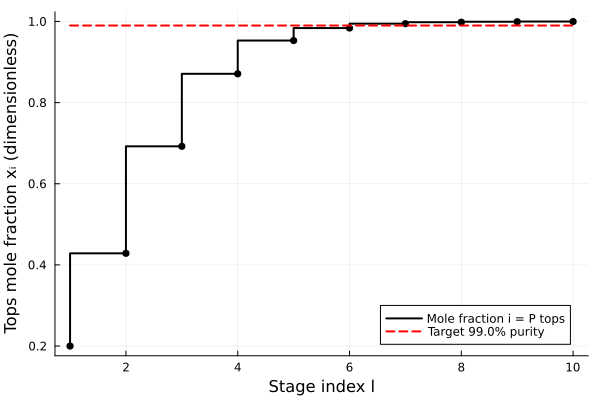

In [13]:
# visualize -
stages = (1:number_of_levels) |> collect
plot(stages,species_mole_fraction_array_top[idx_target_compound,:], linetype=:steppre,lw=2,legend=:bottomright, 
		label="Mole fraction i = P tops", markershape=:circle, markercolor=:black, linecolor=:black)
xlabel!("Stage index l",fontsize=18)
ylabel!("Tops mole fraction xᵢ (dimensionless)",fontsize=18)

# make a 𝒫 line target line - 
target_line = 𝒫 *ones(number_of_levels)
plot!(stages, target_line, color="red", lw=2,linestyle=:dash, label="Target $(𝒫*100)% purity")